In [1]:
import pass_logit

In [2]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

In [3]:
# https://stackoverflow.com/a/30241668
theano.config.compute_test_value = 'ignore'

## $\phi_\text{logit}$ approximation accuracy

Here we compare the exact and approximate $\phi_{\text{logit}}$
functions.

In [4]:
def phi_logit(s):
    return -np.log1p(np.exp(-s))

In [5]:
coefs_by_M = {
    2: pass_logit.chebyshev.chebyshev_approximation(phi_logit, 2),
    6: pass_logit.chebyshev.chebyshev_approximation(phi_logit, 6),
}

def chebyshev_logit(s, M):
    return np.dot(
        np.power(s, range(M+1)),
        coefs_by_M[M]
    )

/home/andrew/code/pass-logit/chebyshev.py:29: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  -1, 1)[0])


In the interval $[-4,4]$ the functions appear right on top of each other.

<IPython.core.display.Javascript object>


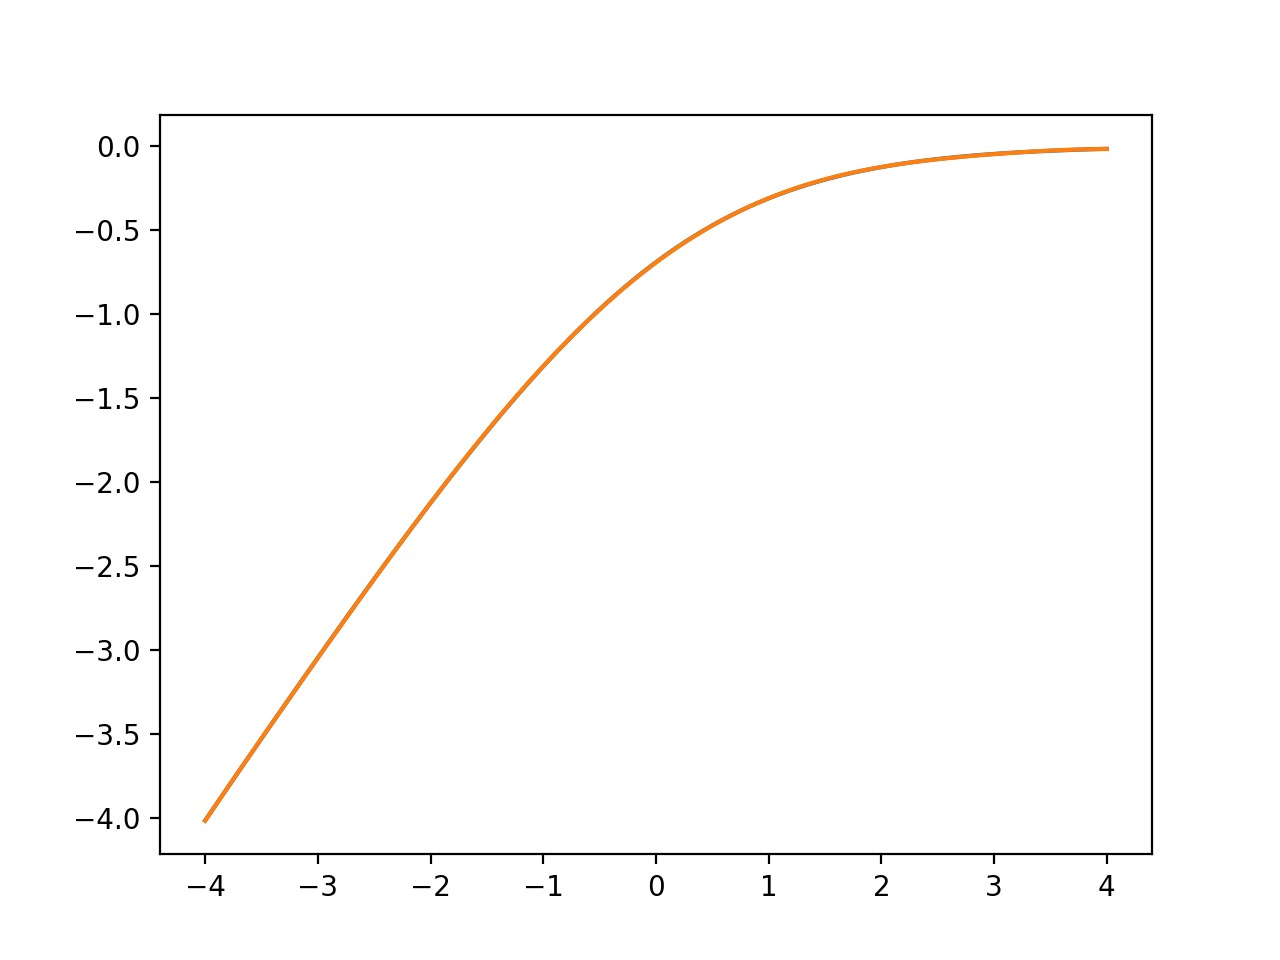

In [6]:
xpts = np.linspace(-4, 4, 1000)
plt.plot(xpts, phi_logit(xpts))
plt.plot(xpts, [chebyshev_logit(xpt, 2) for xpt in xpts])
plt.plot(xpts, [chebyshev_logit(xpt, 6) for xpt in xpts])
plt.show()

## Generating a random dataset

In [7]:
n = 10000
true_coefs = np.array([-0.15, 0.3])

We generate `x` values from a bivariate normal distribution.

In [8]:
xs = np.random.normal(scale=0.5, size=(n, 2))
xs

array([[ 0.21569315,  0.36044811],
       [-1.15002934, -0.51656528],
       [ 0.30182472, -0.31458963],
       ...,
       [ 0.76419481,  0.80161939],
       [ 0.61494416, -0.22486051],
       [-0.02394765, -1.08424731]])

We generate `y` values according to the exact likelihood and
true parameter vector.

In [9]:
# exp ￮ phi_logit
it = lambda x: np.exp(phi_logit(x))

In [10]:
ys = np.random.binomial(
    1, it(1 * (true_coefs * xs).sum(axis=1))) * 2 - 1
ys

array([ 1,  1, -1, ..., -1, -1,  1])

## Preprocessing approximate likelihood

In [11]:
M=6

Obtain $O(1)$-time approximate likelihood function.
$O(n)$ preprocessing happens here.

In [12]:
%%time
log_like_op = pass_logit.get_approx_log_like_op(
    xs=xs,
    ys=ys,
    M=M
)

CPU times: user 3.55 s, sys: 332 ms, total: 3.88 s
Wall time: 3.63 s


## Log likelihood approximation accuracy

Here we compare the exact log likelihood
$\sum_i \phi_\text{logit}(y_i \theta \cdot x_i)$
with the approximate function.

In [13]:
def exact_log_like(theta):
    return np.sum(
        phi_logit(ys * (theta * xs).sum(axis=1))
    )

In [14]:
in1 = theano.tensor.dvector('in1')
approx_log_like = theano.function([in1], log_like_op(in1))

Let's also compute the approximate log likelihood without the preprocessing, just as a test.

In [15]:
# approx log likelihood calculated without preprocessing
def direct_pass(vec):
    return np.sum([
        chebyshev_logit(y * np.dot(vec, x), M=M)
        for x, y in zip(xs, ys)
    ])

In [16]:
(
    exact_log_like([1,2]),
    approx_log_like([1,2]),
    direct_pass([1,2]),
)

(-8009.566790953125, array(-8011.32360801), -8011.323608011511)

We plot the exact log likelihood as a function of the parameter vector.

In [17]:
grid = np.mgrid[-4:4:0.2, -4:4:0.2]
thetaxs, thetays = np.concatenate(grid[0]), np.concatenate(grid[1])

<IPython.core.display.Javascript object>


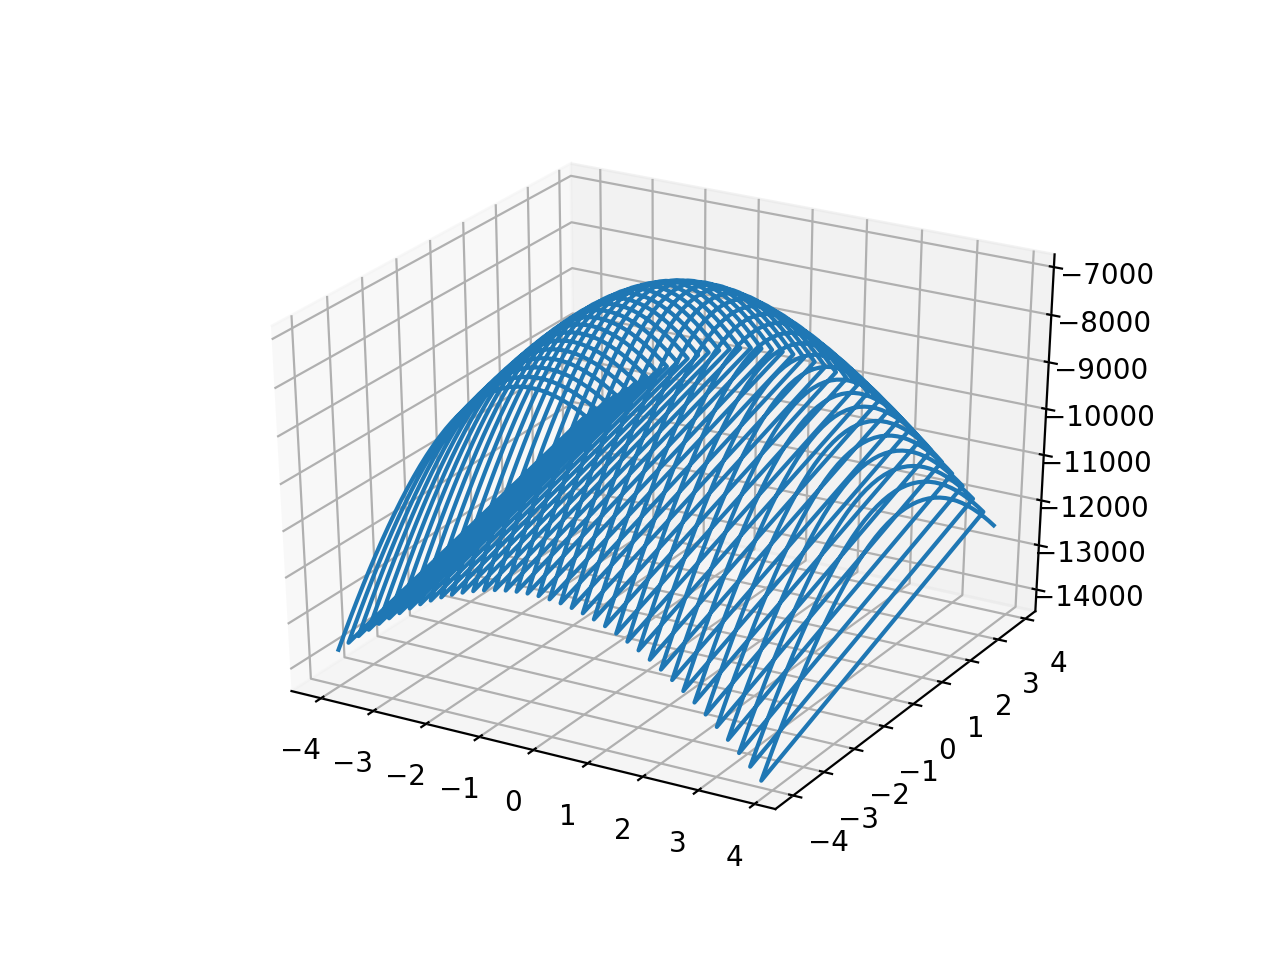

In [18]:
figure = plt.figure()
axis = figure.add_subplot(111, projection = '3d')

axis.plot(
    thetaxs,
    thetays,
    [
        exact_log_like([thetax, thetay])
        for thetax, thetay in zip(thetaxs, thetays)
    ],
)
plt.show()

We plot the difference between the exact and approximate
log likelihoods _per data point_ as a function of the parameter vector.

In [26]:
bound = 3
grid = np.mgrid[-bound:bound:0.2, -bound:bound:0.2]
thetaxs, thetays = np.concatenate(grid[0]), np.concatenate(grid[1])

<IPython.core.display.Javascript object>


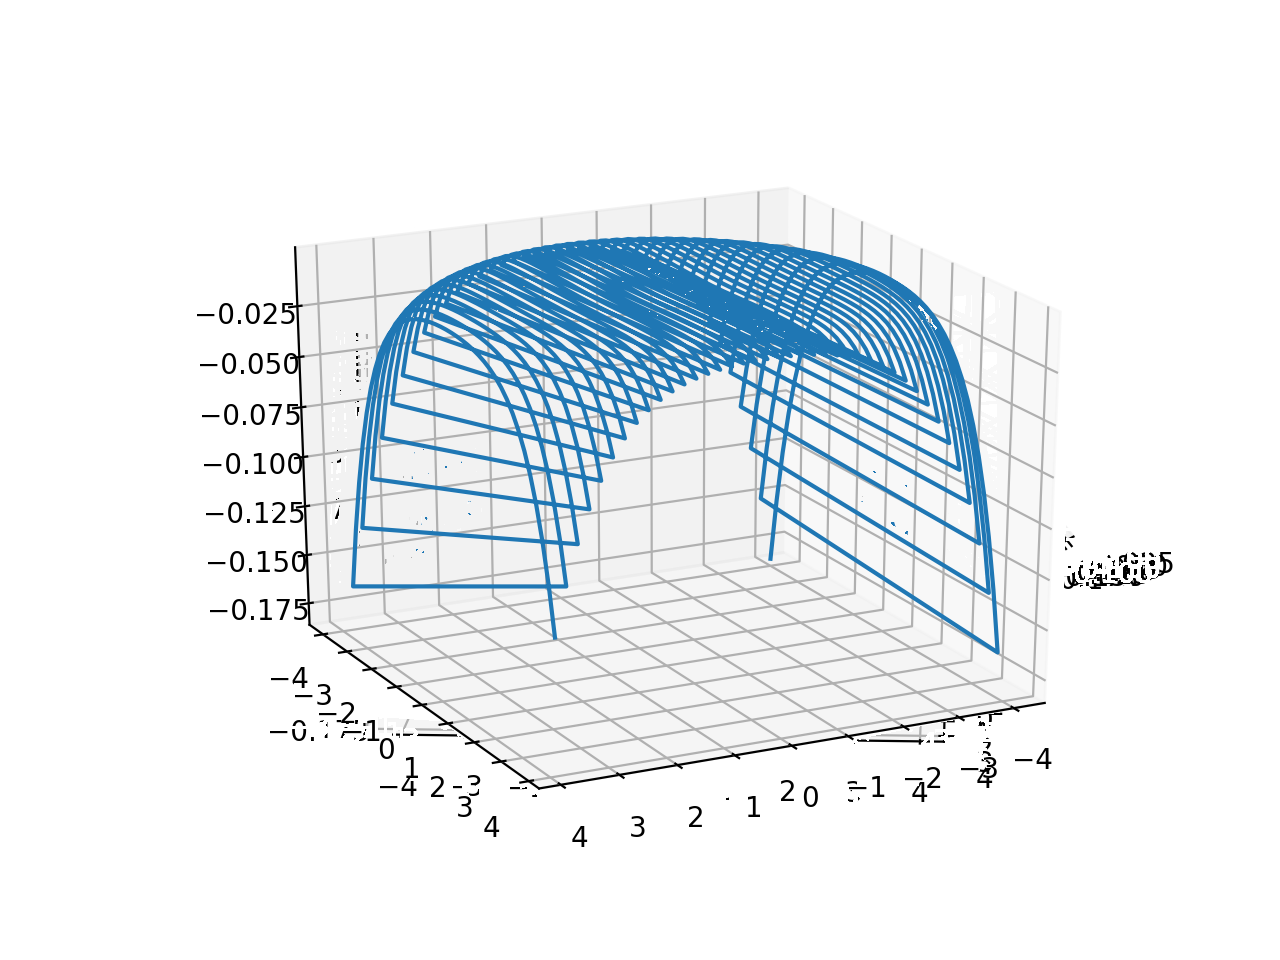

In [19]:
# average absolute error
figure = plt.figure()
axis = figure.add_subplot(111, projection = '3d')

axis.plot(
    thetaxs,
    thetays,
    [
        (approx_log_like([thetax, thetay]) -
        exact_log_like([thetax, thetay])) / n
        for thetax, thetay in zip(thetaxs, thetays)
    ],
)
plt.show()

## Inference

We give our approximate log likelihood and prior to PyMC3 and
obtain samples from the posterior.

In [24]:
%%time
with pm.Model() as model:
    # prior
    coefs_dist = pm.MvNormal(
        'coefs',
        mu=np.zeros(2),
        cov=np.array([[2,0], [0,2]]),
        shape=(2,)
    )
    
    theta = theano.tensor.as_tensor_variable(coefs_dist)
    pm.DensityDist(
        'likelihood', lambda v: log_like_op(v), observed={'v': theta})
    
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coefs]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 539.50draws/s]

CPU times: user 4.47 s, sys: 544 ms, total: 5.01 s
Wall time: 24.6 s


The posterior marginals are represented here.

In [25]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
coefs__0,-0.174522,0.041772,0.000381,-0.255690,-0.093462,10763.107562,0.999906
coefs__1,0.332890,0.040308,0.000380,0.254565,0.411513,10791.500230,0.999936


<IPython.core.display.Javascript object>


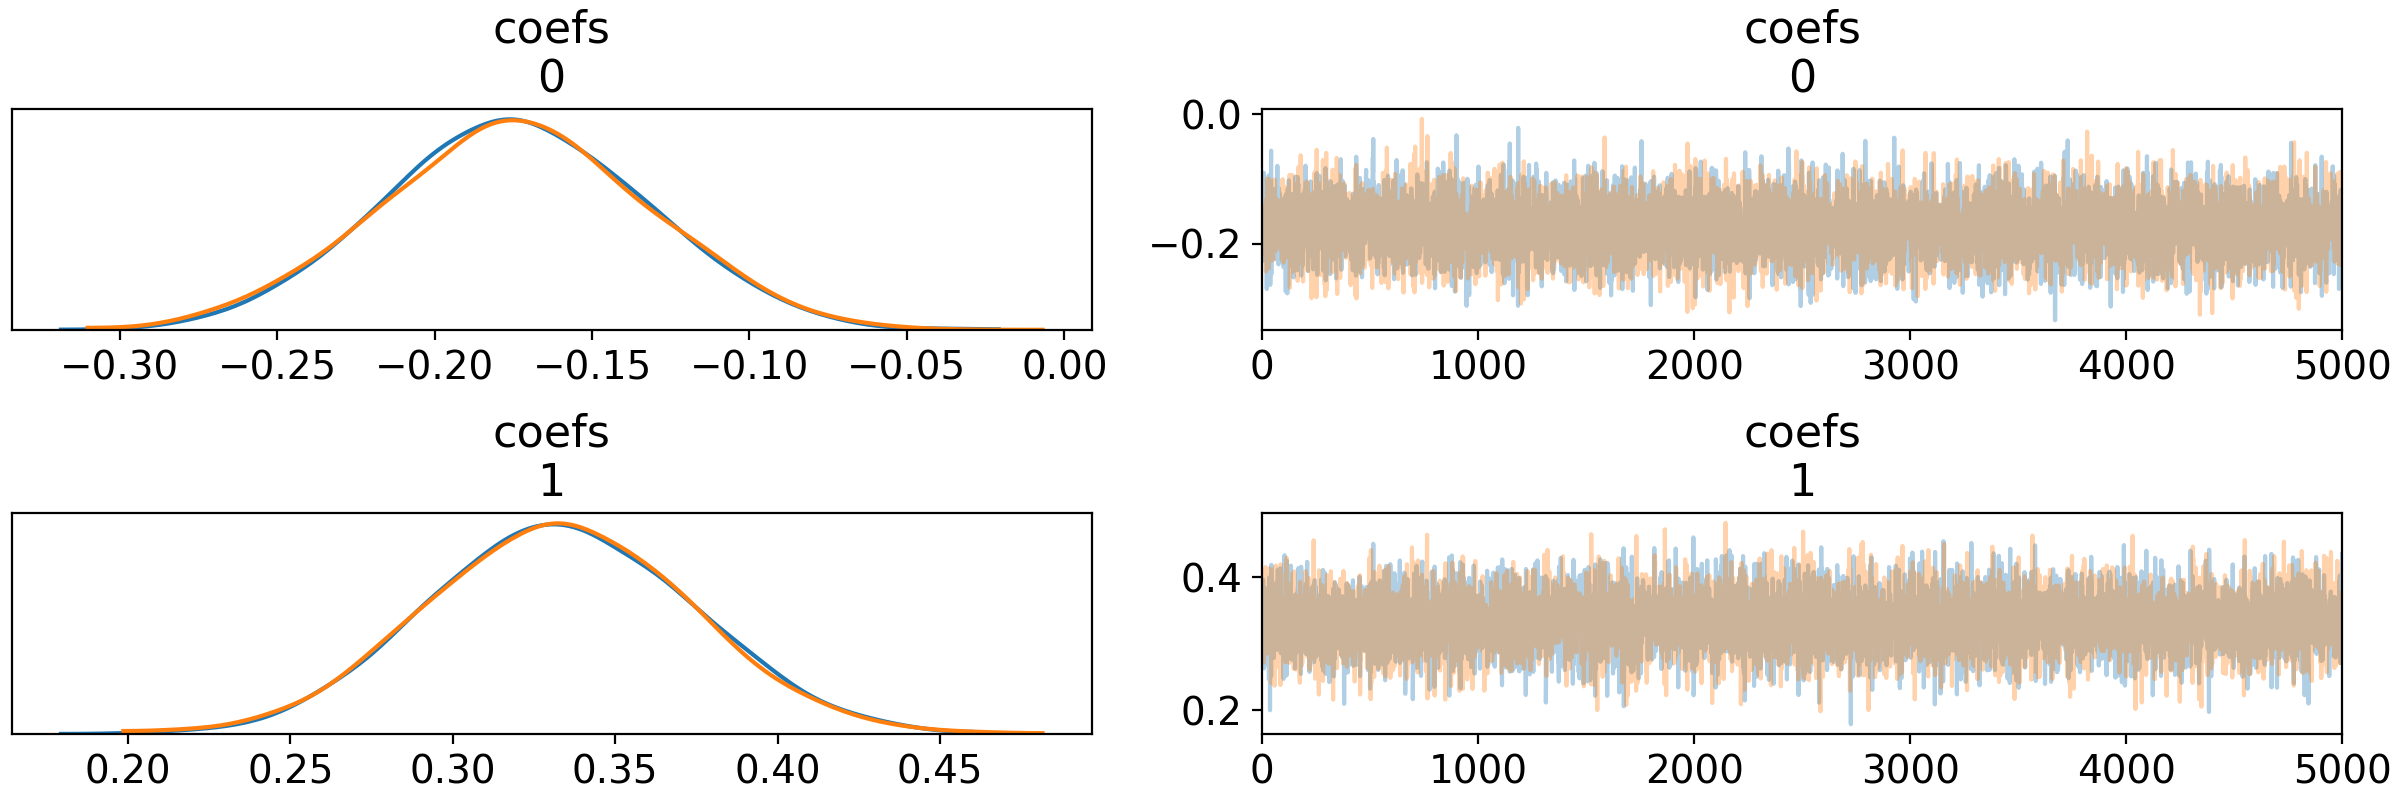

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89bae78f60>,
      dtype=object)

In [26]:
pm.traceplot(trace)

## Posterior predictive distributions

Posterior predictive distributions are available as usual.
See https://docs.pymc.io/notebooks/posterior_predictive.html#Prediction.